Adapted code from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

Imports:

In [1]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.1.0
Torchvision Version:  0.3.0


Data definitions

Note, we need to re-structure our data like such:
top level:
/photos <br />
Next (split training data into train and val before this):<br />
/photos/train<br />
/photos/val<br />
Next (for each class):<br />
/photos/train/class#<br />
/photos/val/class#<br />
Finally (for each photo):<br />
photos/(train or val)/class#/filename<br />

In [2]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "/shared-data/custom_grouped_split/"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 13

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for 
num_epochs = 50

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = False

Helper function for training model

In [3]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

Stops gradient ascent from updating earlier weights when doing feature extracting

In [4]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

Changes the last layer of the model to correspond to the correct output size that we want

In [5]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/ngotm/.cache/torch/checkpoints/resnet18-5c106cde.pth
52.5%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

Data Normalization:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Initializing Datasets and Dataloaders...
{'Arctic': 0, 'Cold_Arid': 1, 'Hot_Arid': 2, 'Hot_Continental': 3, 'Humid_Subtropical': 4, 'Mediterranean': 5, 'Ocean': 6, 'Oceanic': 7, 'Subarctic': 8, 'Tropical_Monsoon': 9, 'Tropical_Rainforest': 10, 'Tropical_Savanna': 11, 'Warm_Continental': 12}
['Arctic', 'Cold_Arid', 'Hot_Arid', 'Hot_Continental', 'Humid_Subtropical', 'Mediterranean', 'Ocean', 'Oceanic', 'Subarctic', 'Tropical_Monsoon', 'Tropical_Rainforest', 'Tropical_Savanna', 'Warm_Continental']
3089


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

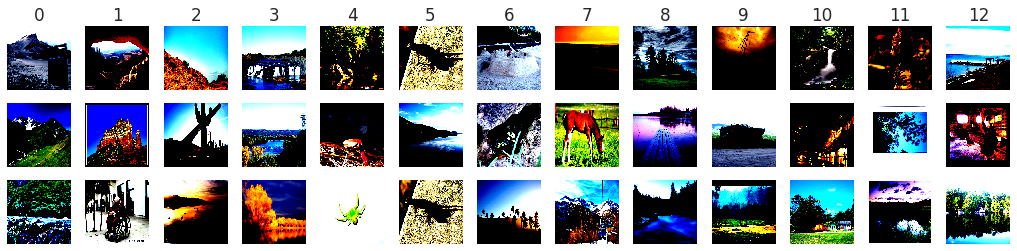

In [165]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

print(image_datasets['val'].class_to_idx)
print(image_datasets['val'].classes)
#print(image_datasets['val'].imgs[0:3089:240])
print(len(image_datasets['val']))
for i in range(13):
    #idxs = image_datasets['val'][i*240:i*240+240]
    #idxs = np.random.choice(idxs, 4, replace=False)
    
    
    #print(climate)
    for j in range(3):
        img = image_datasets['val'][i*240 + j][0].permute(1,2,0).numpy()[:,:,:]
        climate = image_datasets['val'][i*240 + j][1]
        ax = plt.subplot(3, 13, j*13 + i + 1)
        ax.axis('off')
        if j == 0:
            ax.set_title(climate)
            
        plt.imshow(img)
    
    if i == 12:
        fig = plt.gcf()
        fig.set_size_inches(18, 4)
        plt.show()
        break

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Defines which parameters are needed to fit (for feature extraction its just the last layer)

In [7]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [8]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/49
----------
train Loss: 2.4726 Acc: 0.1579
val Loss: 2.3166 Acc: 0.2091

Epoch 1/49
----------
train Loss: 2.2831 Acc: 0.2160
val Loss: 2.2534 Acc: 0.2286

Epoch 2/49
----------
train Loss: 2.2032 Acc: 0.2449
val Loss: 2.2131 Acc: 0.2363

Epoch 3/49
----------
train Loss: 2.1421 Acc: 0.2688
val Loss: 2.1970 Acc: 0.2366

Epoch 4/49
----------
train Loss: 2.1039 Acc: 0.2768
val Loss: 2.1841 Acc: 0.2441

Epoch 5/49
----------
train Loss: 2.0531 Acc: 0.2960
val Loss: 2.1648 Acc: 0.2574

Epoch 6/49
----------
train Loss: 2.0170 Acc: 0.3105
val Loss: 2.1775 Acc: 0.2622

Epoch 7/49
----------
train Loss: 1.9874 Acc: 0.3239
val Loss: 2.1775 Acc: 0.2661

Epoch 8/49
----------
train Loss: 1.9389 Acc: 0.3325
val Loss: 2.2011 Acc: 0.2596

Epoch 9/49
----------
train Loss: 1.9070 Acc: 0.3506
val Loss: 2.1807 Acc: 0.2719

Epoch 10/49
----------
train Loss: 1.8559 Acc: 0.3731
val Loss: 2.1716 Acc: 0.2791

Epoch 11/49
----------
train Loss: 1.8182 Acc: 0.3820
val Loss: 2.2043 Acc: 0.2745

Ep

In [9]:
model_ft.classifier

AttributeError: 'ResNet' object has no attribute 'classifier'

Saving model parameters:

In [10]:
torch.save(model_ft, 'full_group_resnet.pt')

loading back in model:

In [11]:
test_load = torch.load('full_group_resnet.pt')
test_load.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

# Getting Results

In [33]:
train_loss = [2.5,2.4,2.367,2.3415,2.3136,2.3088,2.2844,2.2688,2.2495,2.2419,2.2289,2.2150,2.2045,2.1976,2.1889,2.1853,2.1683,2.1600,2.1471,2.1410,2.1337,2.1240,2.1193,2.1121,2.1009,2.0918,2.0865,2.0786,2.0771,2.0554,2.0563,2.0553,2.0409,2.0279,2.0315,2.0325,2.0095,1.9941,1.9997,2.00,1.989,1.971,1.976,1.9554,1.9622,1.9454,1.9311,1.9451,1.9348,1.9253]

In [47]:
val_loss = [2.411,2.3525,2.3598,2.3158,2.3,2.2819,2.2638,2.2547,2.2691,2.2658,2.239,2.2295,2.2332,2.245,2.251,2.2351,2.2183,2.234,2.2239,2.21,2.204,2.2077,2.2246,2.2264,2.2365,2.2547,2.2678,2.2713,2.2369,2.2322,2.2299,2.2317,2.2228,2.2949,2.3011,2.2161,2.2443,2.2772,2.3024,2.2562,2.2893,2.3161,2.2893,2.3416,2.261,2.2595,2.2959,2.82,2.3904,2.3239]

In [48]:
train_acc = [.1334,.1724,.1888,.1958,.2067,.2108,.215,.2259,.2243,.2324,.2343,.2417,.2457,.2496,.2530,.2597,.2592,.267,.268,.271,.2735,.2798,.2812,.2836,.2835,.2903,.2940,.294,.2921,.3047,.3046,.3034,.3093,.3115,.3141,.3118,.3191,.3255,.3255,.3249,.3249,.3324,.3307,.3389,.3392,.3443,.3463,.3421,.3451,.3475]

In [49]:
val_acc = [hist[i].item() for i in range (len(hist))]

In [50]:
len(val_acc)

50

In [51]:
len(train_acc)

50

In [52]:
len(val_loss)

50

In [53]:
len(train_loss)

50

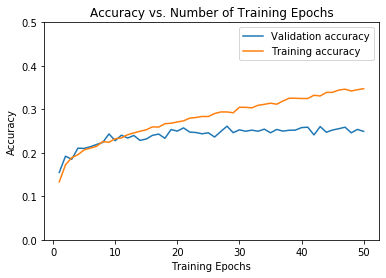

In [59]:
plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,num_epochs+1),val_acc,label="Validation accuracy")
plt.plot(range(1,num_epochs+1),train_acc,label="Training accuracy")
plt.ylim((0,.5))
#plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

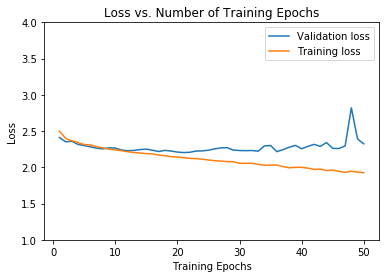

In [64]:
plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,num_epochs+1),val_loss,label="Validation loss")
plt.plot(range(1,num_epochs+1),train_loss,label="Training loss")
plt.ylim((1,4))
#plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

## test set performance

In [12]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms['val']) for x in ['test']}

In [13]:
image_datasets

{'test': Dataset ImageFolder
     Number of datapoints: 3839
     Root location: /shared-data/custom_grouped_split/test}

In [14]:
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['test']}

In [15]:
dataloaders_dict

{'test': <torch.utils.data.dataloader.DataLoader at 0x7f7b6c6d40f0>}

In [16]:
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [17]:
for epoch in range(1):
    for phase in ['test']:
        running_loss = 0.0
        running_corrects = 0
        predicted_labels = []
        true_labels = []
        for inputs, labels in dataloaders_dict[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            predicted_labels.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(dataloaders_dict[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders_dict[phase].dataset)


In [18]:
epoch_loss

3.4509144862762

In [19]:
epoch_acc

tensor(0.3084, device='cuda:0', dtype=torch.float64)

In [20]:
print(predicted_labels)

[5, 0, 4, 12, 7, 6, 9, 0, 11, 5, 0, 0, 9, 5, 0, 9, 1, 9, 1, 9, 2, 2, 5, 5, 5, 11, 9, 7, 12, 12, 0, 3, 9, 10, 0, 4, 12, 7, 12, 7, 9, 0, 3, 5, 6, 6, 3, 10, 7, 0, 4, 5, 9, 3, 5, 2, 9, 6, 7, 6, 12, 12, 2, 7, 7, 10, 6, 12, 10, 10, 10, 2, 0, 1, 10, 6, 9, 6, 9, 2, 3, 3, 4, 11, 11, 4, 3, 11, 3, 9, 3, 1, 10, 6, 6, 12, 0, 12, 8, 10, 12, 12, 1, 0, 0, 4, 6, 1, 8, 0, 1, 11, 1, 5, 10, 12, 4, 12, 11, 10, 3, 9, 3, 8, 1, 6, 9, 0, 1, 5, 7, 0, 0, 1, 4, 4, 5, 3, 6, 12, 7, 0, 11, 1, 11, 12, 8, 6, 9, 2, 3, 10, 7, 3, 2, 12, 9, 9, 9, 7, 4, 7, 5, 5, 5, 9, 10, 2, 11, 6, 10, 9, 1, 8, 1, 2, 3, 7, 5, 12, 6, 9, 3, 8, 10, 10, 2, 6, 4, 0, 0, 1, 9, 7, 9, 1, 11, 0, 10, 6, 7, 3, 12, 3, 12, 12, 0, 12, 1, 0, 3, 2, 10, 7, 9, 3, 7, 7, 2, 1, 4, 11, 5, 11, 11, 9, 1, 7, 11, 4, 2, 5, 11, 1, 5, 9, 7, 8, 2, 8, 11, 12, 5, 9, 9, 9, 8, 6, 2, 9, 12, 9, 0, 7, 9, 12, 12, 8, 6, 7, 3, 10, 6, 9, 11, 8, 3, 8, 10, 4, 9, 7, 1, 9, 5, 6, 7, 12, 12, 7, 1, 1, 9, 3, 6, 12, 1, 12, 5, 4, 2, 4, 1, 6, 4, 3, 0, 12, 10, 2, 11, 10, 7, 8, 9, 8, 11, 12, 8

# Confusion

In [21]:
import matplotlib.pyplot as plt
import seaborn as sn

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics  import confusion_matrix
print(classification_report(true_labels, predicted_labels))
cm = confusion_matrix(true_labels, predicted_labels)

              precision    recall  f1-score   support

           0       0.54      0.51      0.52       295
           1       0.34      0.41      0.37       297
           2       0.34      0.30      0.32       295
           3       0.31      0.33      0.32       298
           4       0.18      0.14      0.16       300
           5       0.19      0.17      0.18       300
           6       0.33      0.40      0.36       293
           7       0.20      0.16      0.17       300
           8       0.35      0.35      0.35       298
           9       0.29      0.44      0.35       287
          10       0.43      0.32      0.37       287
          11       0.32      0.29      0.30       290
          12       0.18      0.21      0.20       299

    accuracy                           0.31      3839
   macro avg       0.31      0.31      0.31      3839
weighted avg       0.31      0.31      0.31      3839



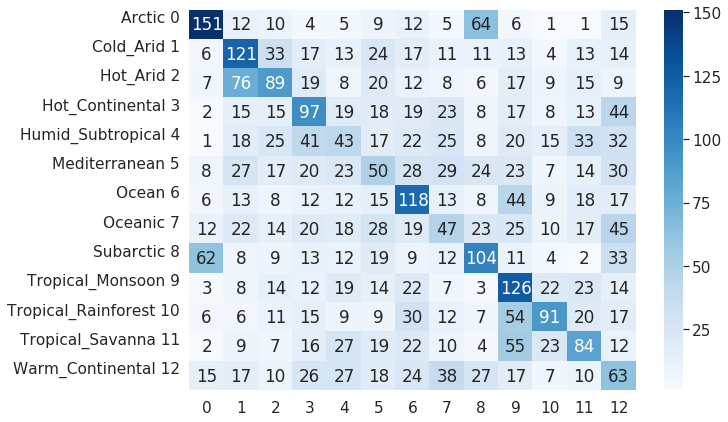

In [194]:
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(cm.astype(int), annot=True,cmap='Blues', fmt='g')
#plt.yticks(rotation=0) 
climates = ['Arctic 0', 'Cold_Arid 1', 'Hot_Arid 2', 'Hot_Continental 3', 'Humid_Subtropical 4', 'Mediterranean 5', 'Ocean 6', 'Oceanic 7', 'Subarctic 8', 'Tropical_Monsoon 9', 'Tropical_Rainforest 10', 'Tropical_Savanna 11', 'Warm_Continental 12']
plt.yticks(np.arange(13), labels=climates,rotation=0,  va="top");